In [1]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

%matplotlib notebook

In [423]:
swath_bounds1 = [
    (19.55, 28.74),
    (28.74, 33.98),
    (33.98, 39.19),
    (39.19, 43.44),
    (43.44, 46.50)
]

swath_bounds = [
    (19.55, 28.60),
    (28.80, 33.95),
    (34.05, 39.15),
    (39.25, 43.40),
    (43.50, 46.50)
]

In [518]:
ifiles = glob.glob('s1a_npz/nesz_ESA_*npz')[:-1]
swaths = 5
preds = 3
preds_sig = 3

a1_list = []
a2_list = []
b_list = []
c_list = []
n0n_list = []
n0_list = []
for i, ifile in enumerate(ifiles):
    basename = os.path.basename(ifile).replace('nesz_ESA_', '')

    n0 = np.load('s1a_npz/nesz_ESA_%s' % basename)['nesz_ESA']
    s0 = np.load('s1a_npz/s0_%s' % basename)['s0']
    if np.nanmean(s0) > 0.002:
        continue
    n0n = np.load('s1a_npz/nesz_NERSC_%s' % basename)['nesz_NERSC']
    inc = np.load('s1a_npz/inc_%s' % basename)['inc']

    
    a1 = []
    a2 = []
    b = []
    c = []
    n0ns = []
    n0s = []
    for swi in range(0,swaths):
        cols = np.where((inc >= swath_bounds[swi][0]) * ((inc < swath_bounds[swi][1])))[0]
        a1sub = np.zeros((cols.size, preds*swaths))
        a1sub[:, swi*preds+0] = np.ones_like(cols)
        a1sub[:, swi*preds+1] = n0[cols]
        a1sub[:, swi*preds+2] = uniform_filter1d(s0[cols], 400)
        a1.append(a1sub)
        b.append(s0[cols])
        c.append(cols)
        n0ns.append(n0n[cols])
        n0s.append(n0[cols])

        a2sub = np.zeros((cols.size, preds_sig*(swaths+1)))

        sw_mid_bound = (swath_bounds[swi][0] + swath_bounds[swi][1]) / 2
        cols1 = np.where((inc >= swath_bounds[swi][0]) * (inc < sw_mid_bound))[0]
        iswi = 0
        a2sub[:cols1.size, (swi+0)*preds_sig+0] = np.ones_like(cols1)
        a2sub[:cols1.size, (swi+0)*preds_sig+1] = np.cos(np.radians(inc[cols1]))
        a2sub[:cols1.size, (swi+0)*preds_sig+2] = np.cos(np.radians(inc[cols1])) ** 2

        cols2 = np.where((inc >= sw_mid_bound) * (inc < swath_bounds[swi][1]))[0]
        a2sub[cols1.size:, (swi+1)*preds_sig+0] = np.ones_like(cols2)
        a2sub[cols1.size:, (swi+1)*preds_sig+1] = np.cos(np.radians(inc[cols2]))
        a2sub[cols1.size:, (swi+1)*preds_sig+2] = np.cos(np.radians(inc[cols2])) ** 2

        a2.append(a2sub)

    a1_list.append(np.vstack(a1))
    a2_list.append(np.vstack(a2))
    b_list.append(np.hstack(b))
    c_list.append(np.hstack(c))
    n0n_list.append(np.hstack(n0ns))
    n0_list.append(np.hstack(n0s))
a1all = np.vstack(a1_list)
b = np.hstack(b_list)
c = np.hstack(c_list)

a2_list2 = []
for i, a2 in enumerate(a2_list):
    a2file = []
    for j in range(len(a2_list)):
        if i == j:
            a2file.append(a2)
        else:
            a2file.append(np.zeros_like(a2))
    a2_list2.append(np.hstack(a2file))
a2all = np.vstack(a2_list2)
a = np.hstack([a1all, a2all])
print(a.shape)

(80970, 159)


In [519]:
x = np.linalg.lstsq(a, b, rcond=None)[0]

<IPython.core.display.Javascript object>


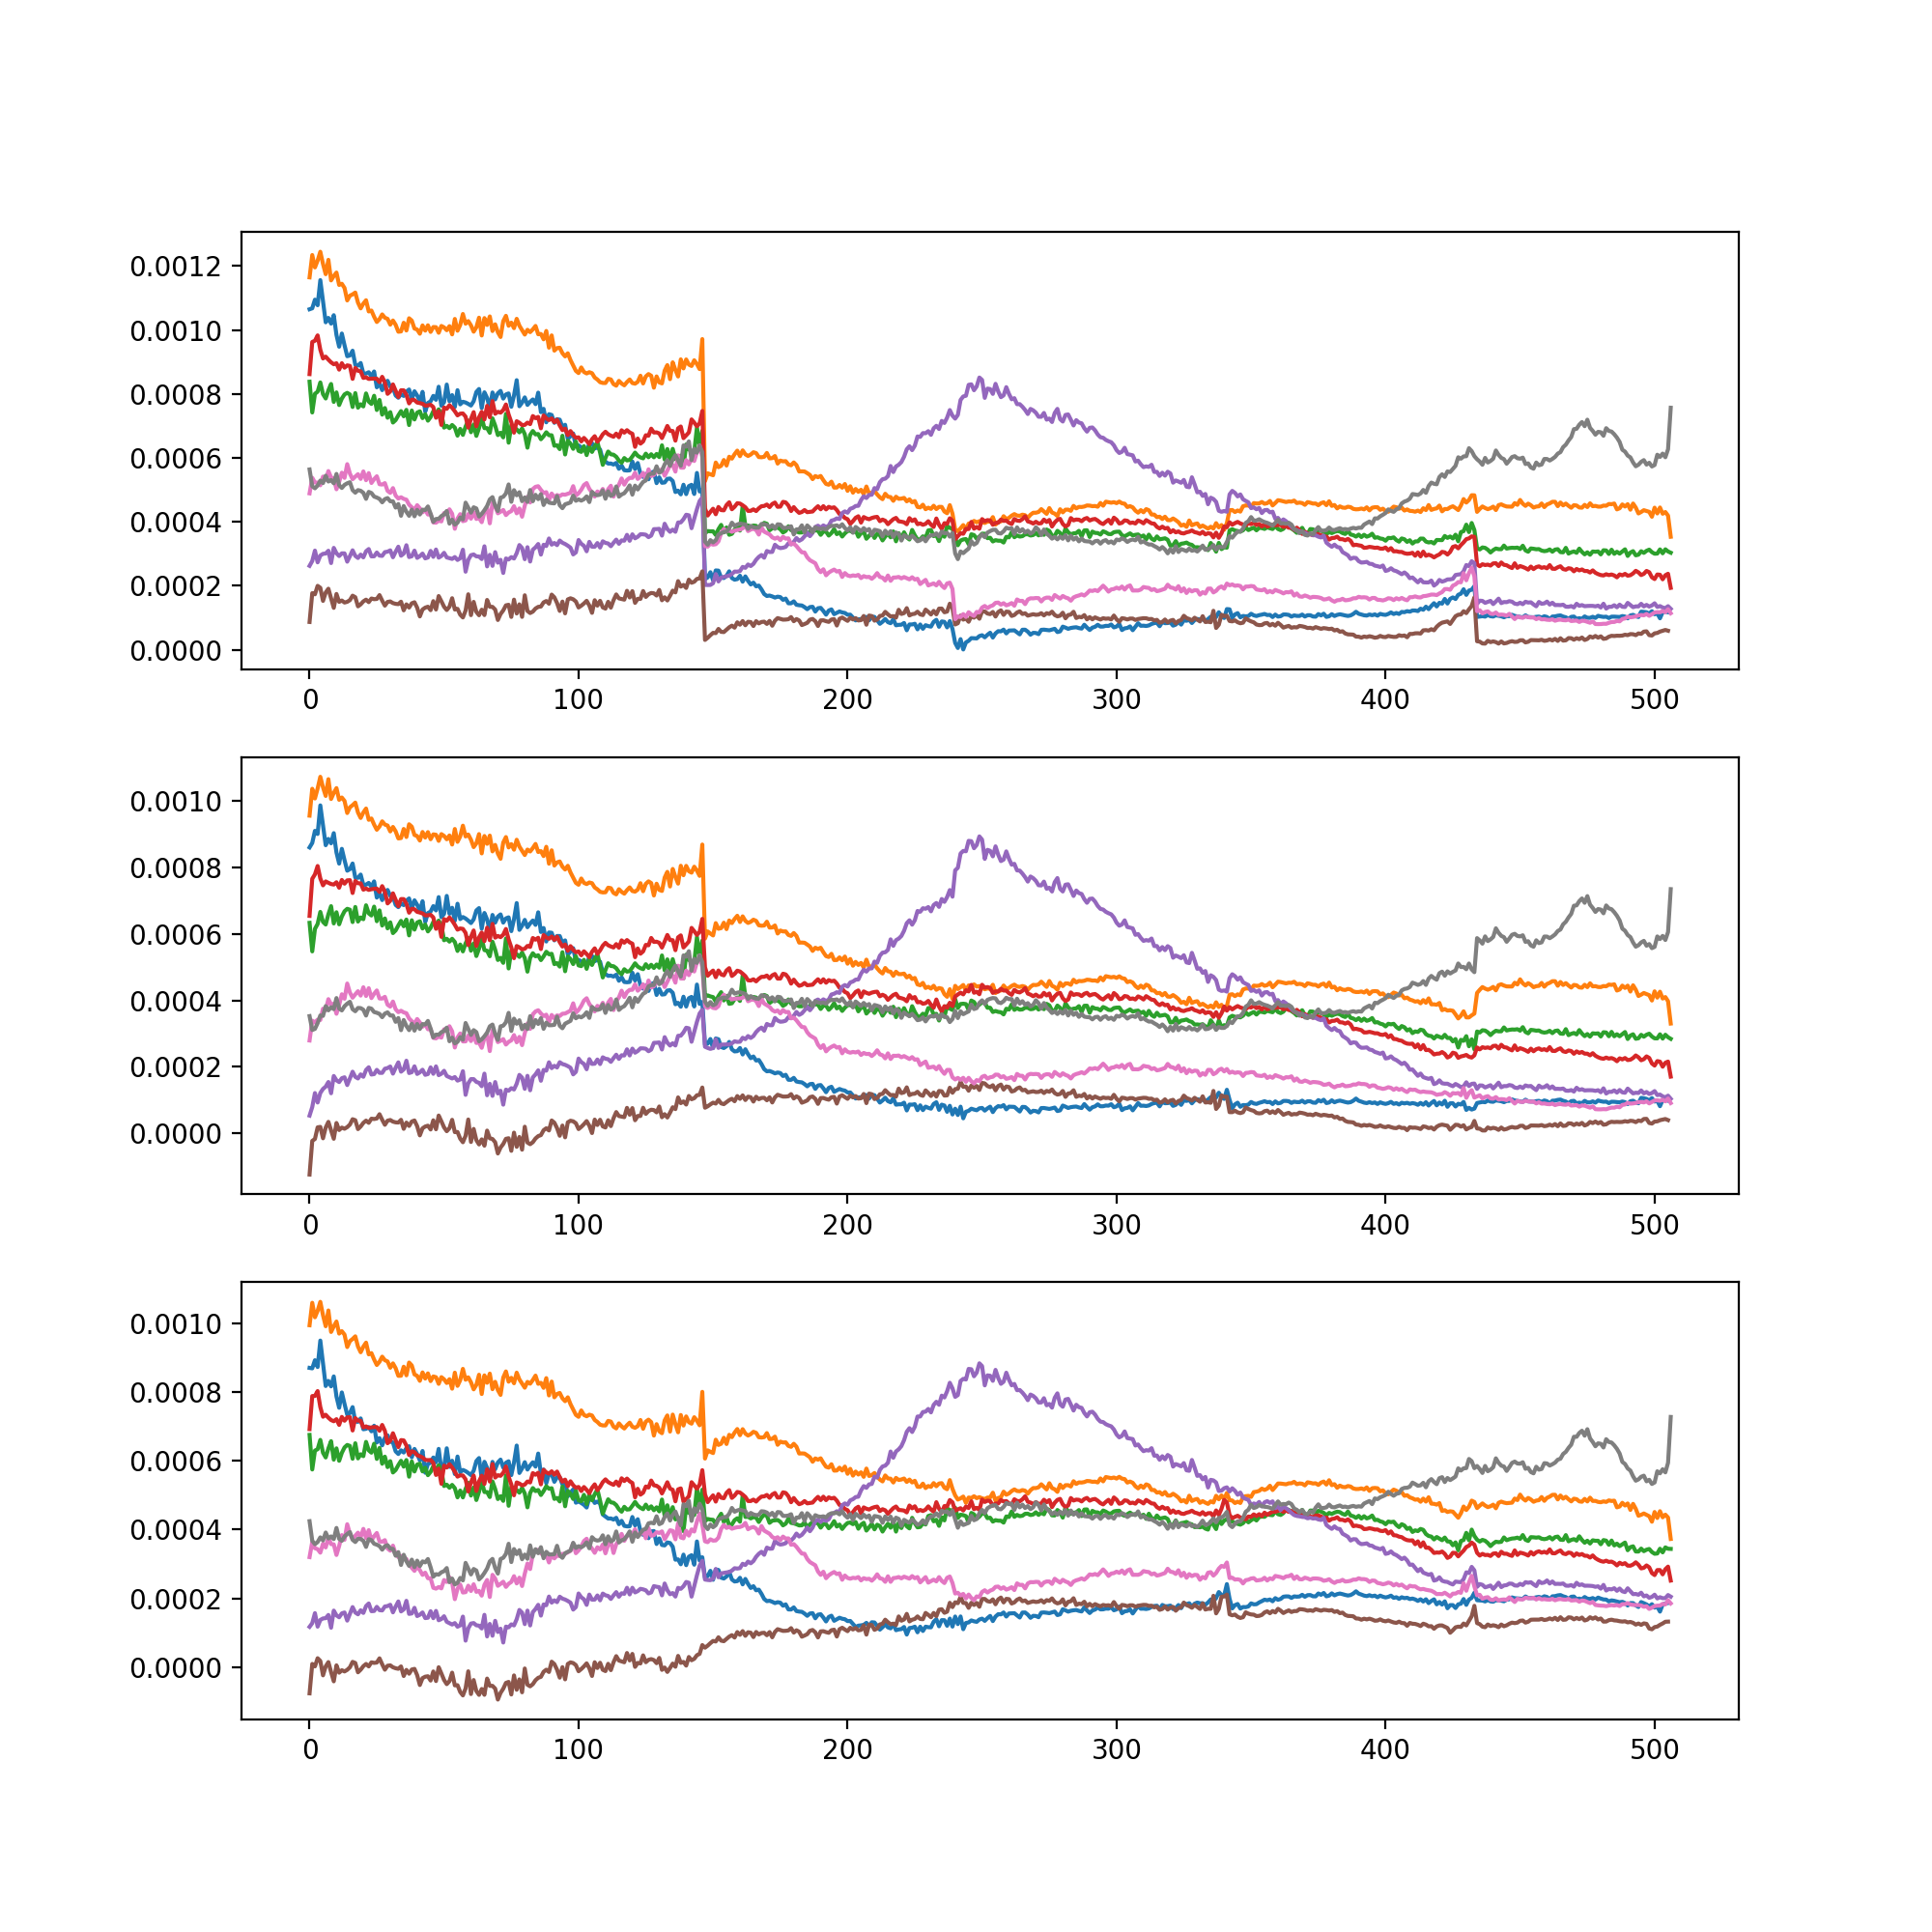

In [520]:
stp=20
fig, ax = plt.subplots(3,1, figsize=(10,10))
for i in range(len(a1_list)):
    Bs = np.dot(a1_list[i], x[:swaths*preds])
    Bs = Bs - Bs.mean() + n0_list[i].mean()
    ax[0].plot(b_list[i][::stp] - n0_list[i][::stp])
    ax[1].plot(b_list[i][::stp] - n0n_list[i][::stp])
    ax[2].plot(b_list[i][::stp] - Bs[::stp])

plt.show()

<IPython.core.display.Javascript object>


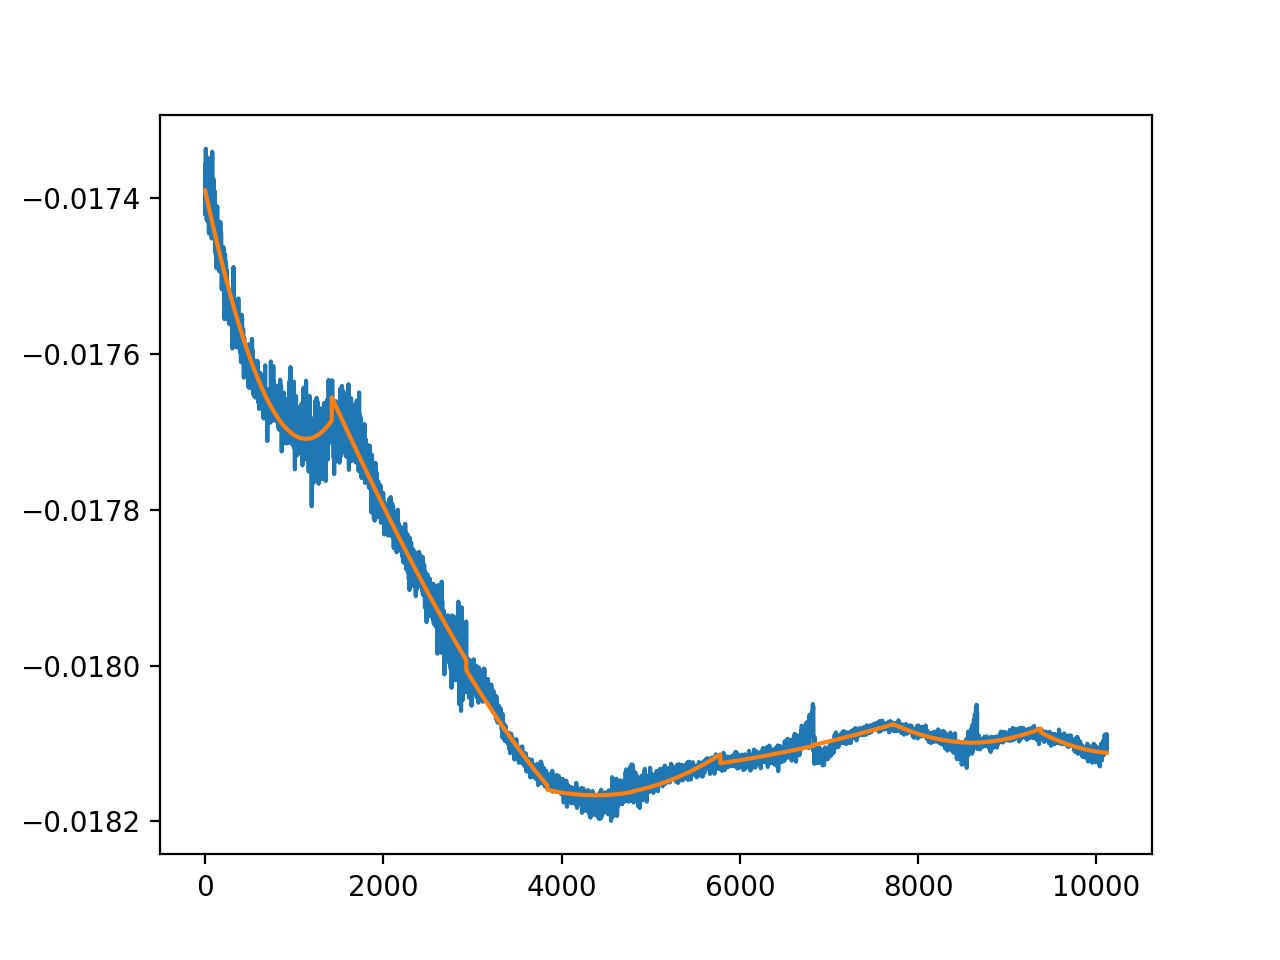

<IPython.core.display.Javascript object>


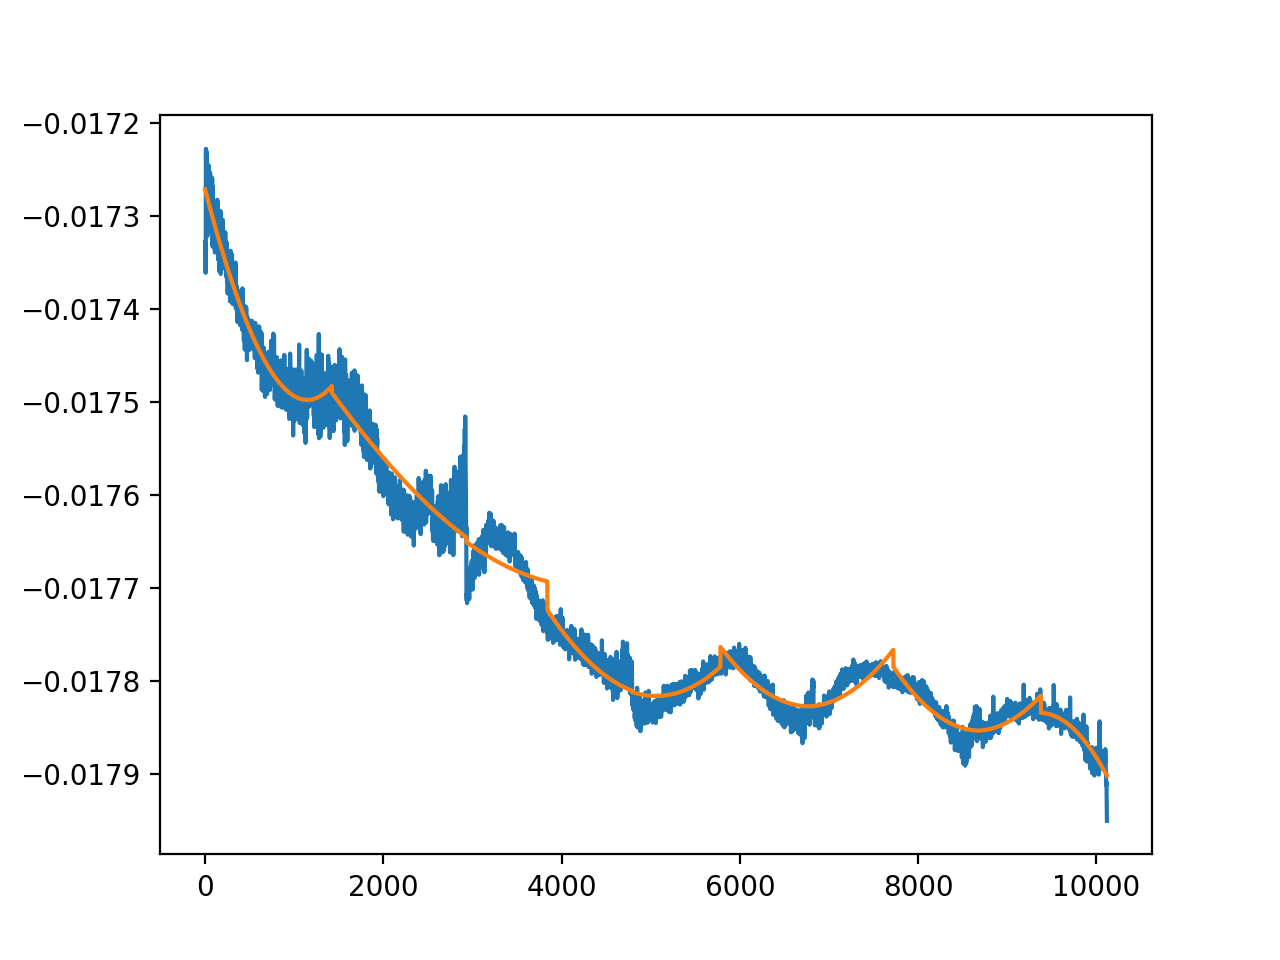

<IPython.core.display.Javascript object>


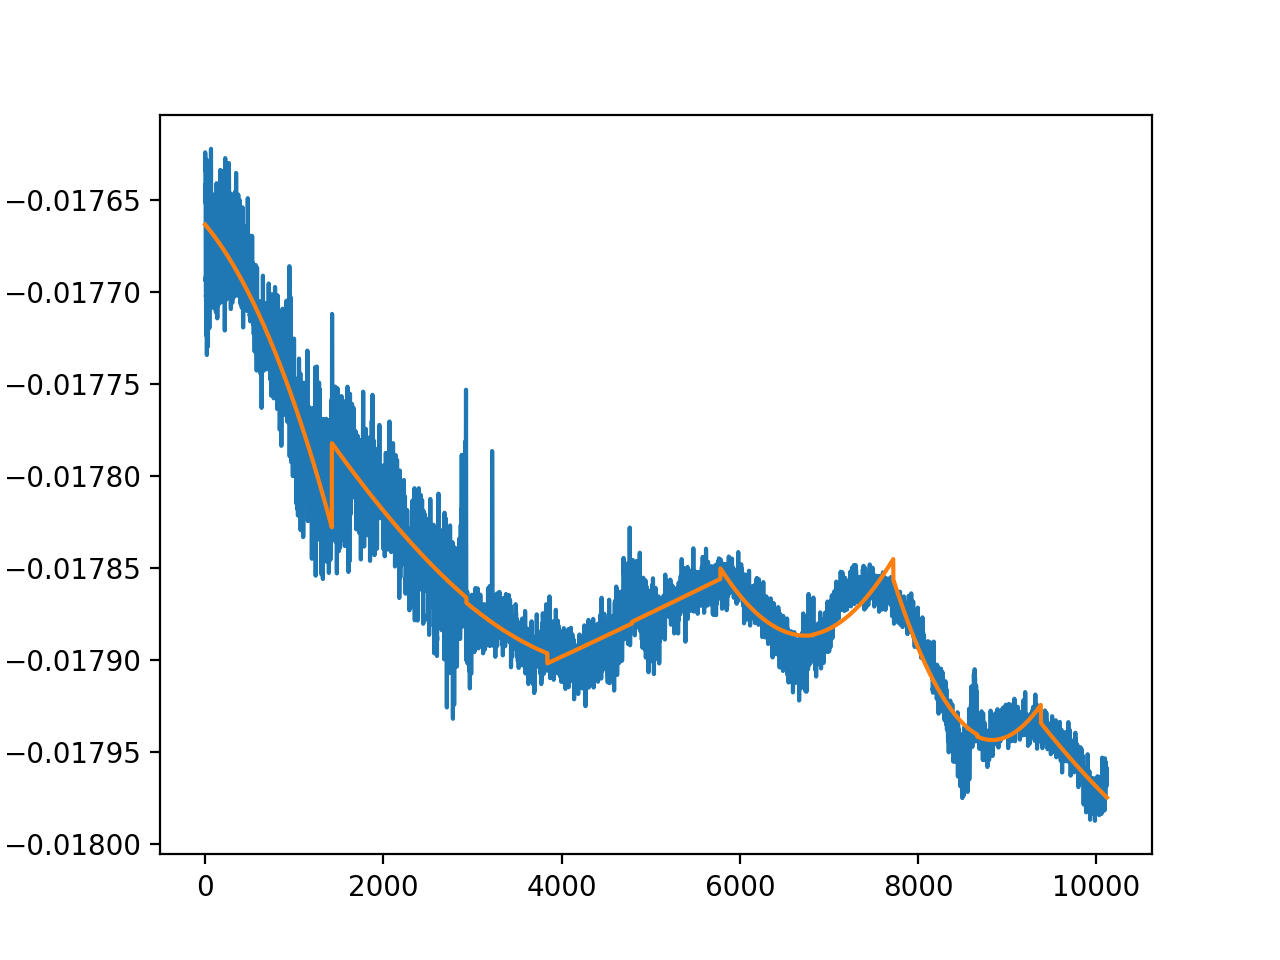

<IPython.core.display.Javascript object>


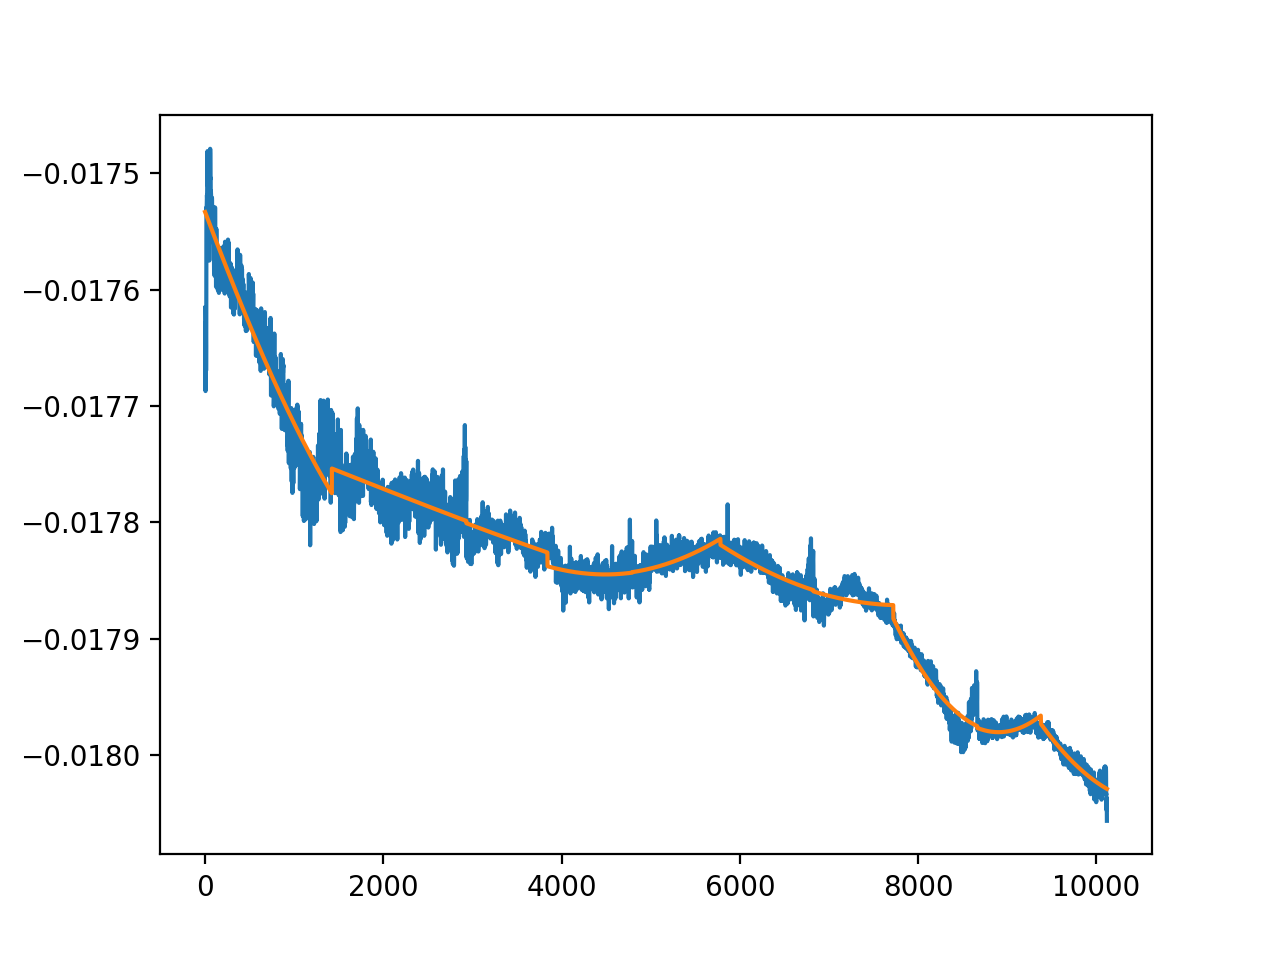

<IPython.core.display.Javascript object>


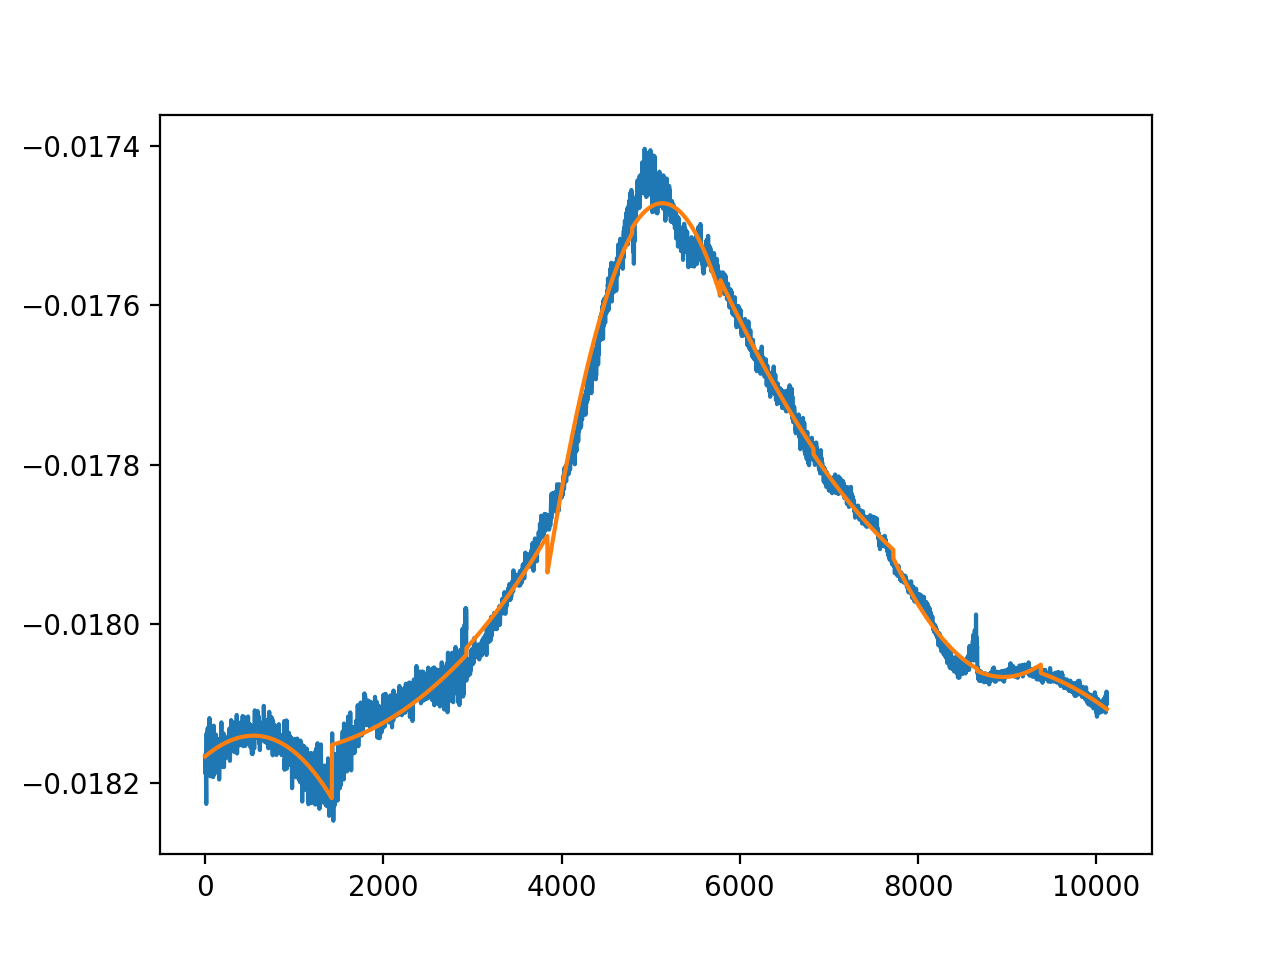

<IPython.core.display.Javascript object>


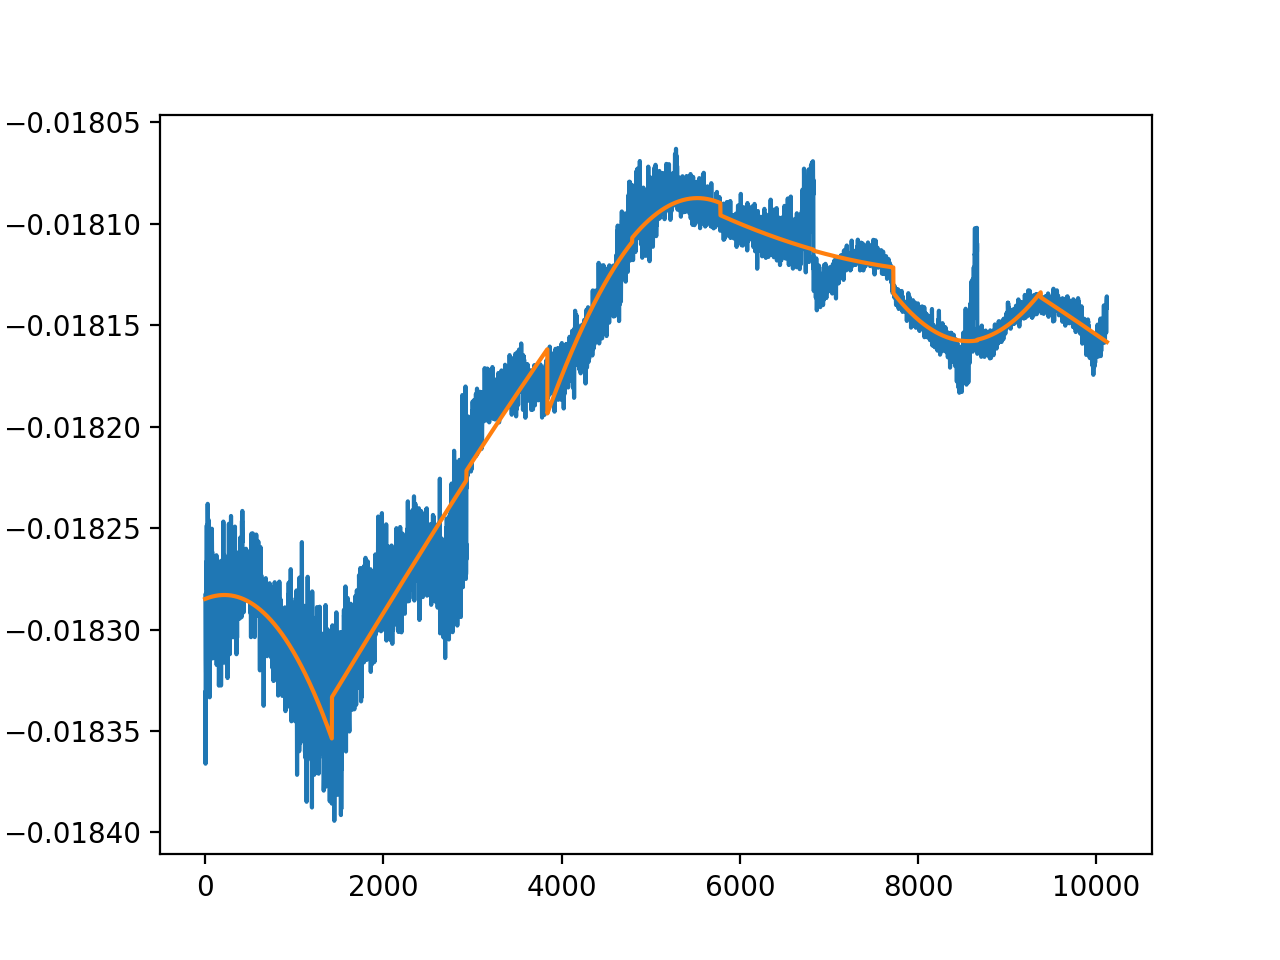

<IPython.core.display.Javascript object>


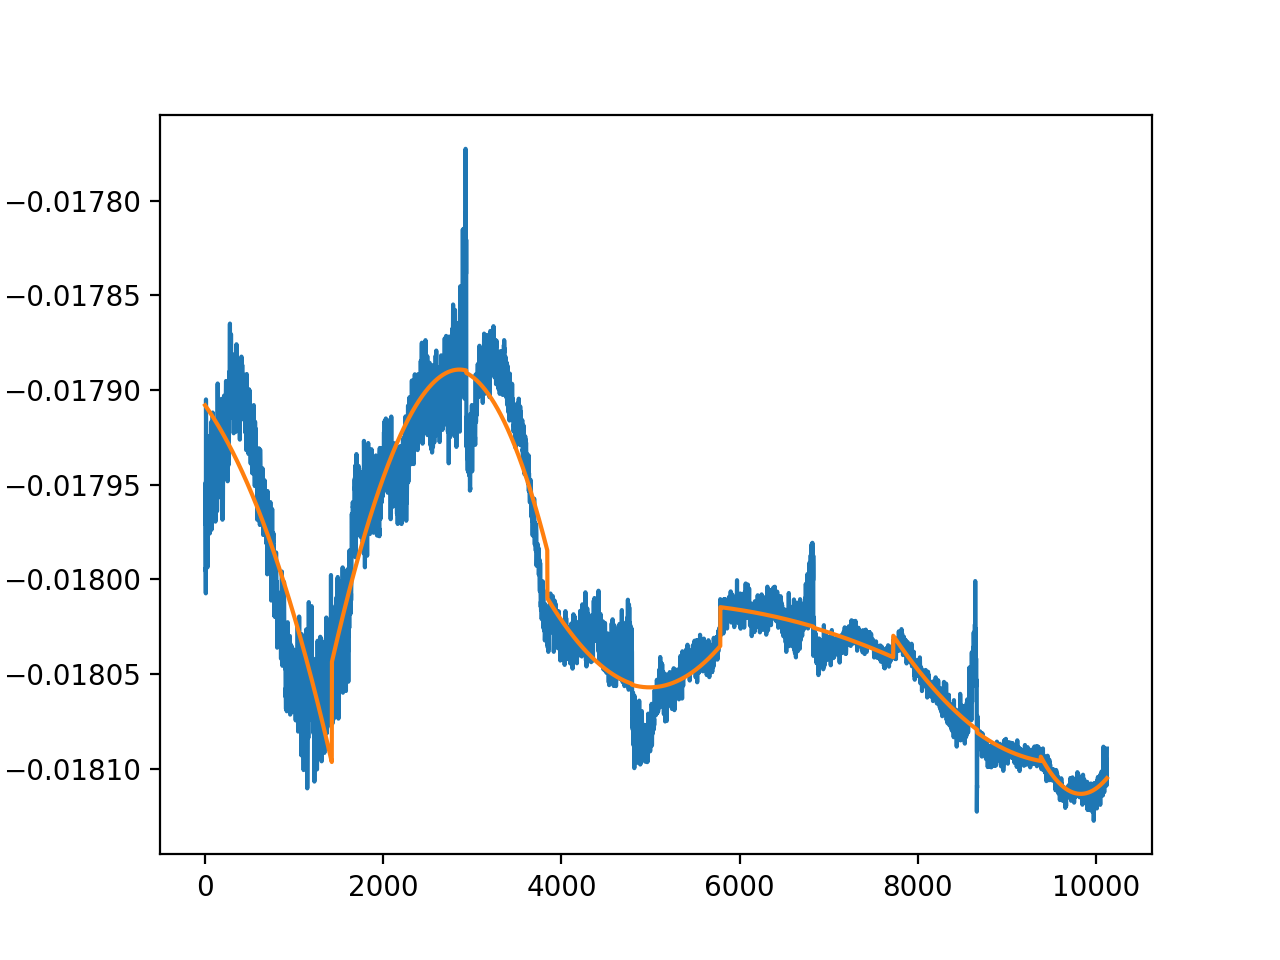

<IPython.core.display.Javascript object>


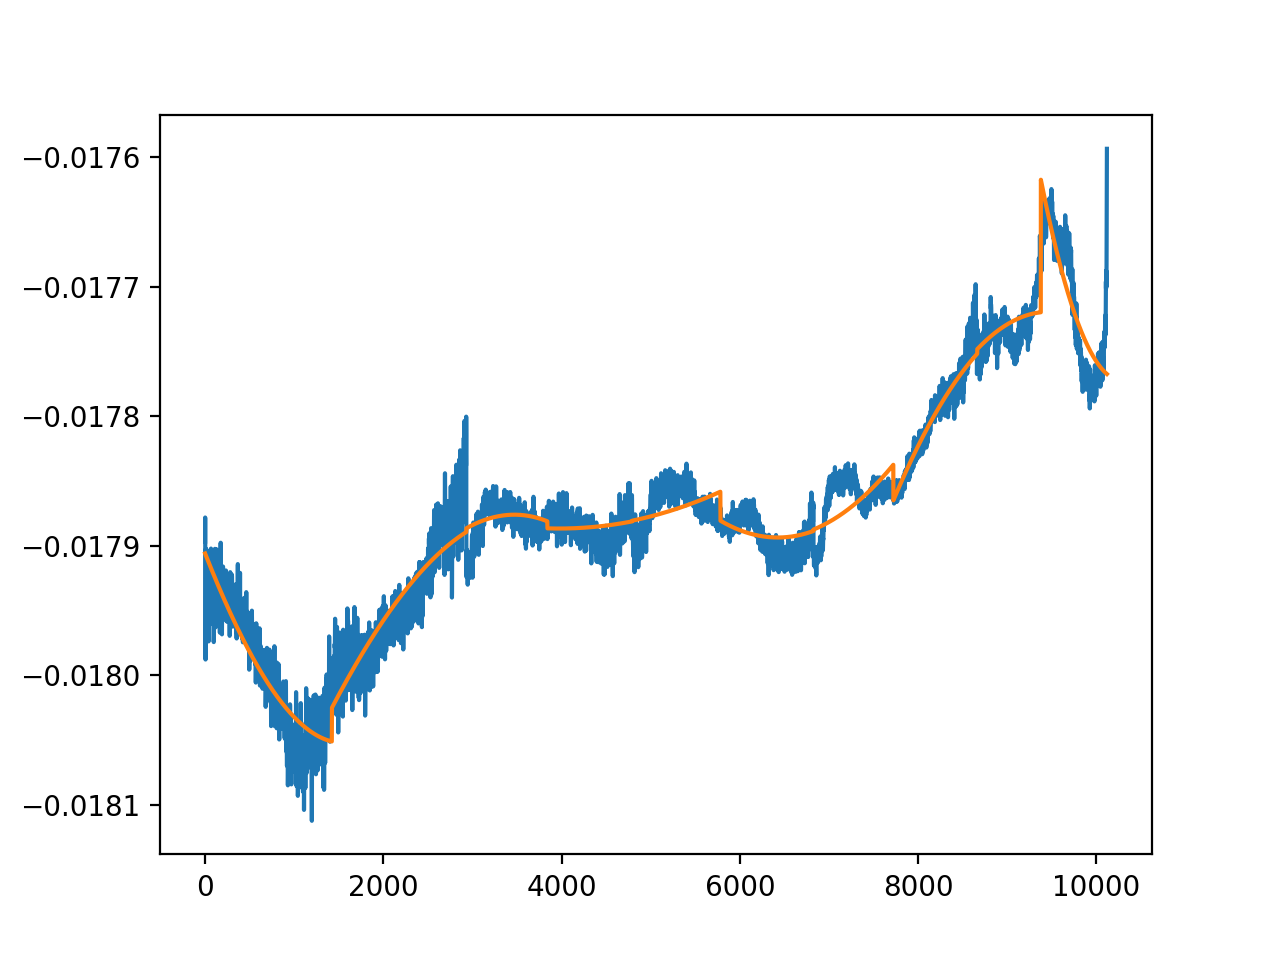

In [517]:
for i in range(len(a1_list)):
    n_new = np.dot(a1_list[i], x[:swaths*preds])
    s_new = np.dot(a2_list2[i], x[swaths*preds:])
    plt.figure()
    plt.plot(b_list[i] - n_new)
    plt.plot(s_new)
    plt.show()

In [487]:
a2_list[i].shape

(10120, 18)

In [489]:
x.shape

(159,)